## Step 1: Data Splitting

In [98]:
import pandas as pd

df = pd.read_csv('btc_processed.csv')

In [99]:
# X_all = df.drop(columns=['date', 'Target'])
X_all = df[['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14']]
y_all = df['Target']

print (f"Feature matrix shape: {X_all.shape}")
print(X_all.head())
print (f"Target vector shape: {y_all.shape}")
print(y_all.head())

Feature matrix shape: (3377, 18)
         open        high         low       close      volume      rsi_7  \
0  226.440994  233.503998  216.309006  217.464005  23348200.0  35.643356   
1  216.867004  231.574005  212.014999  226.972000  29128500.0  43.755389   
2  226.490997  242.175003  222.658997  238.229004  30612100.0  52.095851   
3  237.453995  245.957001  224.483002  227.268005  40783700.0  44.585253   
4  227.511002  230.057999  221.113007  226.852997  26594300.0  44.303116   

      rsi_14      cci_7     cci_14      sma_50      ema_50     sma_100  \
0  39.545291 -98.071536 -51.796943  248.782547  242.606509  248.782547   
1  43.393165 -72.721346 -54.788070  248.100968  241.757327  248.100968   
2  47.642203  -7.891879 -12.669779  247.801817  241.568538  247.801817   
3  44.165876  20.037760 -32.194104  247.197882  240.814145  247.197882   
4  44.034862 -45.057541 -70.859064  246.616599  240.087492  246.616599   

      ema_100      macd   bollinger  TrueRange      atr_7     atr

- sliding windows (for time-series model)

In [100]:
import numpy as np

# defining window size (number of past days to consider for each prediction)
WINDOW_SIZE = 14

# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (3363, 14, 18) y (3363,)


- data splitting

In [101]:
# Train-test split
TRAIN_RATIO = 0.8

# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2690 Test samples: 673


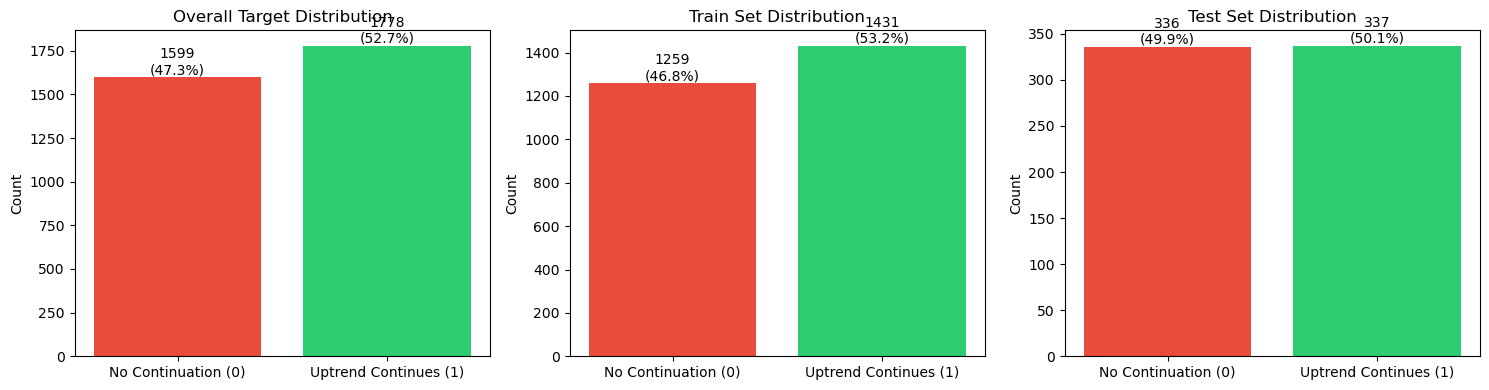


Class balance ratio (Uptrend Continues/No Continuation): 1.112


In [102]:
import matplotlib.pyplot as plt

# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Uptrend Continues/No Continuation): {counts[1]/counts[0]:.3f}')

- Normalization

In [103]:
from sklearn.preprocessing import RobustScaler

# Scaling: Use RobustScaler for better handling of outliers in crypto data
n_features = X_train.shape[2]
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test, preserve 3D shape for LSTM/GRU
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Create both versions: 3D for LSTM/GRU, flat for MLP
X_train_3d = X_train_scaled  # shape: (samples, window_size, features)
X_test_3d = X_test_scaled

print('✓ Using RobustScaler (better for crypto volatility)')
print('3D shape (for LSTM/GRU):', X_train_3d.shape, X_test_3d.shape)

✓ Using RobustScaler (better for crypto volatility)
3D shape (for LSTM/GRU): (2690, 14, 18) (673, 14, 18)


## Step 2: Model Training

- LSTM model

In [104]:
from tensorflow.keras import backend as K

def focal_loss(gamma=None, alpha=None):
    # Use global parameters if not provided
    _gamma = gamma if gamma is not None else FOCAL_GAMMA
    _alpha = alpha if alpha is not None else FOCAL_ALPHA
    
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = _alpha * y_true * K.pow(1 - y_pred, _gamma) + (1 - _alpha) * (1 - y_true) * K.pow(y_pred, _gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, BatchNormalization
from tensorflow.keras.regularizers import l2


# defining model parameters
lr = 0.001
dropout_rate = 0.3
USE_ATTENTION = True
USE_FOCAL_LOSS = True
WINDOW_SIZE = 14  # ensure this matches the window size used earlier

TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42

USE_ATTENTION = True  # Add attention mechanism to LSTM/GRU for better performance
USE_RESIDUAL = True  # Use residual connections for deeper networks
USE_FOCAL_LOSS = True  # Use focal loss to handle class imbalance better
USE_SMOTE = False  # Use SMOTE for synthetic minority oversampling (can help but may overfit)
OPTIMIZE_THRESHOLD = True  # Find optimal classification threshold instead of 0.5

# Focal loss parameters - more aggressive for severe imbalance
FOCAL_GAMMA = 3.0  # Increased from 2.0 - focuses more on hard examples
FOCAL_ALPHA = 0.75  # Increased from 0.25 - gives more weight to minority class

inputs = Input(shape=(WINDOW_SIZE, n_features))

# First Bi-LSTM layer
x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
x = LayerNormalization()(x)
x = Dropout(dropout_rate)(x)

# Second Bi-LSTM layer
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = LayerNormalization()(x)
x = Dropout(dropout_rate)(x)

# Attention mechanism (if enabled)
if USE_ATTENTION:
    # Self-attention layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attention_output])  # Residual connection
    x = LayerNormalization()(x)

# Final LSTM layer
x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
x = Dropout(dropout_rate)(x)

# Dense layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate * 0.7)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(dropout_rate * 0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [106]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 14, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_21    │ (None, 14, 256)   │    150,528 │ input_layer_11[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 256)   │        512 │ bidirectional_21… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 14, 256)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_22    │ (None, 14, 128)   │    164,352 │ dropout_60[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bidirectional_22… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 14, 128)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 14, 128)   │     66,048 │ dropout_61[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_61[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 14, 128)   │          0 │ dropout_61[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 32)        │     20,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 32)        │          0 │ lstm_33[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      2,112 │ dropout_63[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │      2,080 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 32)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1)         │         33 │ dropout_65[0][0]

 Total params: 407,041 (1.55 MB)

 Trainable params: 406,913 (1.55 MB)

 Non-trainable params: 128 (512.00 B)

In [107]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print('Class weights:', class_weights)

# Learning rate schedule with warmup
def lr_schedule(epoch, lr):
    """Learning rate schedule with warmup"""
    if epoch < 5:
        # Warmup phase
        return lr * (epoch + 1) / 5
    elif epoch < 30:
        return lr
    elif epoch < 60:
        return lr * 0.5
    elif epoch < 90:
        return lr * 0.25
    else:
        return lr * 0.1

# Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, and LR Schedule
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_auc', patience=25, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-7, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
checkpoint = ModelCheckpoint('best_model_temp.h5', monitor='val_auc', mode='max', 
                            save_best_only=True, verbose=1)

print(f'\n🎯 Starting training with {len(X_train_3d)} samples...')
print(f'Validation split: {int(len(X_train_3d) * 0.15)} samples')

history = model.fit(
    X_train_3d, y_train,
    epochs=200,  # Increased for better convergence
    batch_size=64,  # Increased for faster training and better generalization
    validation_split=0.15,
    class_weight=class_weights,
    callbacks=[es, reduce_lr, checkpoint],
    shuffle=False,  # Keep chronological order
    verbose=2
)

print(f'\n✅ Training completed!')
print(f'Total epochs: {len(history.history["loss"])}')
print(f'Best val_loss: {min(history.history["val_loss"]):.4f}')
print(f'Best val_auc: {max(history.history["val_auc"]):.4f}')
if 'val_precision' in history.history:
    print(f'Best val_precision: {max(history.history["val_precision"]):.4f}')
    print(f'Best val_recall: {max(history.history["val_recall"]):.4f}')

Class weights: {0: 1.068308181096108, 1: 0.9399021663172606}

🎯 Starting training with 2690 samples...
Validation split: 403 samples
Epoch 1/200


KeyboardInterrupt: 

## Step 4: Model Inferencing

In [ ]:
# Evaluate on test set
results = model.evaluate(X_test_3d, y_test, verbose=0)
print(f'  Loss: {results[0]:.4f}')
print(f'  Accuracy: {results[1]:.4f}')
print(f'  AUC: {results[2]:.4f}')
if len(results) > 3:
    print(f'  Precision: {results[3]:.4f}')
    print(f'  Recall: {results[4]:.4f}')
    f1 = 2 * (results[3] * results[4]) / (results[3] + results[4] + 1e-7)
    print(f'  F1-Score: {f1:.4f}')

  Loss: 0.4171
  Accuracy: 0.4814
  AUC: 0.4883
  Precision: 0.4854
  Recall: 0.5905
  F1-Score: 0.5328


## Step 5: Model Evaluation

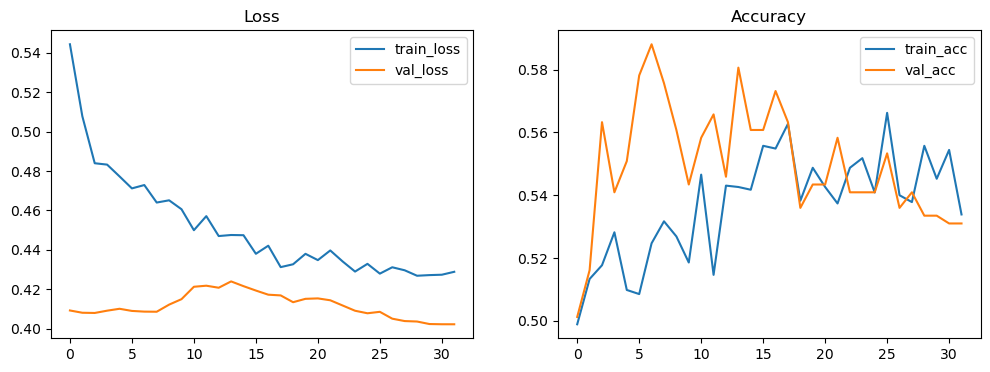

In [ ]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

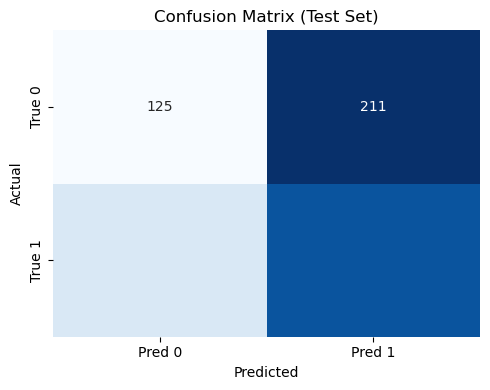

TN: 125, FP: 211, FN: 138, TP: 199
Precision: 0.4854, Recall: 0.5905, F1: 0.5328


In [ ]:
# Confusion matrix on test set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_prob = model.predict(X_test_3d, verbose=0).ravel()
# Use default threshold 0.5 (or tune if needed)
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Optional: print supporting metrics
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
precision = tp / (tp + fp + 1e-7)
recall = tp / (tp + fn + 1e-7)
f1 = 2 * precision * recall / (precision + recall + 1e-7)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')